In [2]:
import sys
sys.path.append("/home/salmon/workspace/fy_trans/python")
from geqdsk import *


In [3]:
eqdsk=sp_read_geqdsk("/home/salmon/workspace/ATEC/g062585.03800")

[&lt;matplotlib.lines.Line2D at 0x7f0b24f3fa30&gt;]

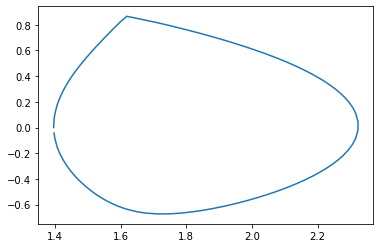

In [31]:
from matplotlib import pylab
pylab.plot( [ p[0] for p in eqdsk["bbsrz"][:-1].tolist()],[ p[1] for p in eqdsk["bbsrz"][:-1].tolist()])


In [43]:
Polygon([Point(p) for p in eqdsk["bbsrz"].tolist()[::-1]])


&lt;mshr.cpp.Polygon at 0x7f0b24e6df30&gt;

[&lt;matplotlib.lines.Line2D at 0x7f220a1850a0&gt;,
 &lt;matplotlib.lines.Line2D at 0x7f220a0ee8e0&gt;]

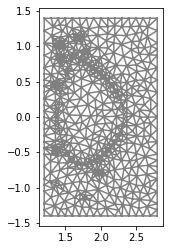

In [14]:
import fenics
import mshr

# Create empty Mesh

domain =mshr.Rectangle(fenics.Point(eqdsk["rleft"],eqdsk["zmid"]-eqdsk["zdim"]/2.0),
              fenics.Point(eqdsk["rleft"]+eqdsk["rdim"],eqdsk["zmid"]+eqdsk["zdim"]/2.0))

domain.set_subdomain(1,mshr.Polygon([ fenics.Point(p) for p in eqdsk["limrz"][::-1]]))
domain.set_subdomain(2,mshr.Polygon([ fenics.Point(p) for p in eqdsk["bbsrz"][::-1]]))


# Generate mesh and plot

mesh= mshr.generate_mesh(domain, 16);

fenics.plot(mesh)


&lt;matplotlib.tri.tricontour.TriContourSet at 0x7f5ebda8b580&gt;

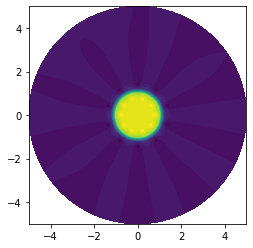

In [4]:
"""
FEniCS tutorial demo program: Magnetic field generated by a copper
wire wound around an iron cylinder. The solution is computed by
solving the Poisson equation for the z-component of the magnetic
vector potential.

  -Laplace(A_z) = mu_0 * J_z

"""

from __future__ import print_function
from fenics import *
from mshr import *
from math import sin, cos, pi

a = 1.0   # inner radius of iron cylinder
b = 1.2   # outer radius of iron cylinder
c_1 = 0.8  # radius for inner circle of copper wires
c_2 = 1.4  # radius for outer circle of copper wires
r = 0.1   # radius of copper wires
R = 5.0   # radius of domain
n = 10    # number of windings

# Define geometry for background
domain = Circle(Point(0, 0), R)

# Define geometry for iron cylinder
cylinder = Circle(Point(0, 0), b) - Circle(Point(0, 0), a)

# Define geometry for wires (N = North (up), S = South (down))
angles_N = [i*2*pi/n for i in range(n)]
angles_S = [(i + 0.5)*2*pi/n for i in range(n)]
wires_N = [Circle(Point(c_1*cos(v), c_1*sin(v)), r) for v in angles_N]
wires_S = [Circle(Point(c_2*cos(v), c_2*sin(v)), r) for v in angles_S]

# Set subdomain for iron cylinder
domain.set_subdomain(1, cylinder)

# Set subdomains for wires
for (i, wire) in enumerate(wires_N):
    domain.set_subdomain(2 + i, wire)
for (i, wire) in enumerate(wires_S):
    domain.set_subdomain(2 + n + i, wire)

# Create mesh
mesh = generate_mesh(domain, 128)

# Define function space
V = FunctionSpace(mesh, 'P', 1)

# Define boundary condition
bc = DirichletBC(V, Constant(0), 'on_boundary')

# Define subdomain markers and integration measure
markers = MeshFunction('size_t', mesh, 2, mesh.domains())
dx = Measure('dx', domain=mesh, subdomain_data=markers)

# Define current densities
J_N = Constant(1.0)
J_S = Constant(-1.0)

# Define magnetic permeability


class Permeability(UserExpression):
    def __init__(self, markers, **kwargs):
        super().__init__(**kwargs)
        self.markers = markers

    def eval_cell(self, values, x, cell):
        if self.markers[cell.index] == 0:
            values[0] = 4*pi*1e-7  # vacuum
        elif self.markers[cell.index] == 1:
            values[0] = 1e-5      # iron (should really be 6.3e-3)
        else:
            values[0] = 1.26e-6   # copper


mu = Permeability(markers, degree=1)

# Define variational problem
A_z = TrialFunction(V)
v = TestFunction(V)
a = (1 / mu)*dot(grad(A_z), grad(v))*dx
L_N = sum(J_N*v*dx(i) for i in range(2, 2 + n))
L_S = sum(J_S*v*dx(i) for i in range(2 + n, 2 + 2*n))
L = L_N + L_S

# Solve variational problem
A_z = Function(V)
solve(a == L, A_z, bc)

# Compute magnetic field (B = curl A)
W = VectorFunctionSpace(mesh, 'P', 1)
B = project(as_vector((A_z.dx(1), -A_z.dx(0))), W)

# Plot solution
plot(A_z)
# plot(B)

# Save solution to file
# vtkfile_A_z = File('magnetostatics/potential.pvd')
# vtkfile_B = File('magnetostatics/field.pvd')
# vtkfile_A_z << A_z
# vtkfile_B << B
